# Exploratory Data Analysis of Sales Information

In this notebook, we will be exploring a dataset containing information about flower sales. 

In [202]:
from classes import DataTransform, DataFrameInfo, DatabaseConnector
from pathlib import Path
import calendar
import glob
import os
import pandas as pd
from matplotlib import pyplot
import seaborn as sns #importing relevant packages and classes

We can extract the information stored within our CSV files into pandas DataFrames, letting us set datatypes, remove unnecessary columns and check for null entries.

In [100]:
item_category_key_df = pd.read_csv('item_category_key.csv')
item_category_key_df.drop(columns='Unnamed: 0', inplace=True) #dropping unnecessary column

print(DataFrameInfo(item_category_key_df).nan_count())

ID          0
Category    0
dtype: int64


In [101]:
item_sold_history_df = pd.read_csv('item_sold_history.csv')
item_sold_history_df.drop(columns='Unnamed: 0', inplace=True) #dropping unnecessary column
DataTransform(item_sold_history_df).to_date(['Date']) #setting datatype of column to datetime

print(DataFrameInfo(item_sold_history_df).nan_count())

Date         0
Unit Sold    0
Item         0
dtype: int64


We can merge the two DataFrames, item_sold_history_df and item_category_key_df, to produce a main table which contains 4 columns, the product ID, product category, date of sale and number of units sold in the transaction.

In [102]:
item_sold_history_df.rename(columns = {'Item' : 'ID'}, inplace = True) #renaming Item column to ID in order to merge tables

merged_df = item_category_key_df.merge(item_sold_history_df, on = 'ID')
merged_df.rename(columns = {'Unit Sold' : 'units_sold',
                            'Category': 'category',
                            'Date': 'date'}, inplace = True)
merged_df.head(5)

,ID,category,date,units_sold
0,it1000892,Lilies,2010-01-01,30
1,it1000892,Lilies,2010-01-02,14
2,it1000892,Lilies,2010-01-03,20
3,it1000892,Lilies,2010-01-04,28
4,it1000892,Lilies,2010-01-05,37


The merged DataFrame can be uploaded to a relational database, allowing for SQL statements to be executed on the data.

In [103]:
engine = DatabaseConnector.init_db_engine('db_creds.yaml')

DatabaseConnector.upload_to_db(merged_df, 'sales_data', engine)

After performing some SQL queries on the relational database, we have some CSV files containing the results of these queries. We can use these files to visualise our insights.

In [293]:
path = 'query_results' 
all_csv_files = glob.glob(os.path.join(path, "*.csv"))

dataframes = {i.split('/')[-1].split('.')[0]:pd.read_csv(i) for i in all_csv_files}

In [296]:
df = dataframes['sales_per_flower']
df.set_index('category', inplace=True)

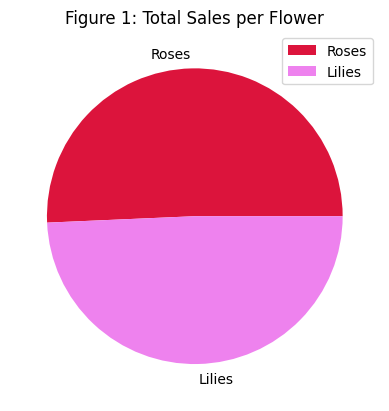

Roses make up 50.69% of all sales, 1.39% more than lilies make up


In [297]:
title='Figure 1: Total Sales per Flower'

df.plot(kind='pie', y='total_sales', colors =['crimson', 'violet'])

pyplot.ylabel(None)
pyplot.title(title)
pyplot.show()

rose_percent = (df['total_sales'].loc['Roses']/ df['total_sales'].sum()) * 100
lilies_percent = (df['total_sales'].loc['Lilies']/ df['total_sales'].sum()) * 100
percent_diff = rose_percent - lilies_percent

print(f'Roses make up {round(rose_percent,2)}% of all sales, {round(percent_diff,2)}% more than lilies make up')


We can see that the total number of sales for roses and lilies over the three year period is very similar, with roses making up only 1.39% more of total sales than lilies.

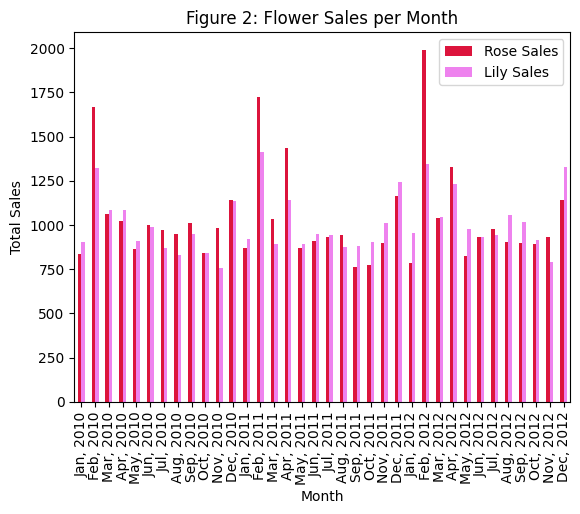

In [298]:
df = dataframes['sales_per_month_3years_roses'].merge(dataframes['sales_per_month_3years_lilies'], on='month') 

def month_trunc(x):
    year_month = x.split('-')[:2]
    return f"{calendar.month_abbr[int(year_month[1])]}, {year_month[0]}"

df['month'] = df['month'].apply(month_trunc)

df.set_index('month', inplace=True)

df.plot(kind='bar', stacked=False, color=['crimson', 'violet', 'skyblue'])

xlab='Month' 
ylab='Total Sales'
title='Figure 2: Flower Sales per Month'

mylabels = ['Rose Sales', 'Lily Sales']
pyplot.xlabel(xlab)
pyplot.ylabel(ylab)
pyplot.title(title)
pyplot.legend(labels=mylabels)
pyplot.show()

Figure 2 shows the total number of sales for roses and lilies in every month of the three year period. There are clear peaks around February and April, likely due to Valentines day and the beginning of spring respectively.

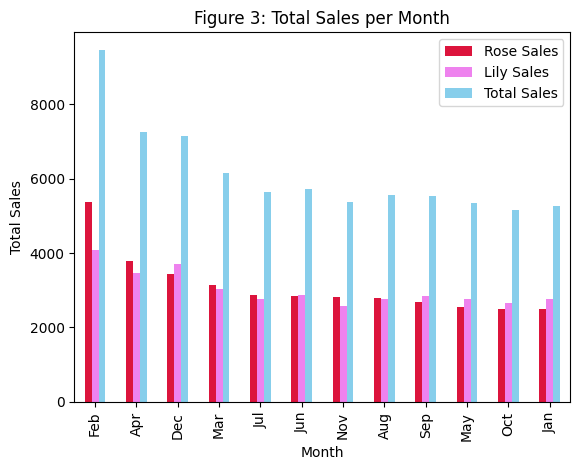

Percentage of sales made up by roses in February: 56.87%


In [299]:
df = dataframes['sales_per_month_roses'].merge(dataframes['sales_per_month_lilies'], on='month') 
sum_df = df.merge(dataframes['sales_per_month'], on='month')

def month_abbr(x):
    return calendar.month_abbr[x]

sum_df['month'] = sum_df['month'].apply(month_abbr)

sum_df.set_index('month', inplace=True)

sum_df.plot(kind='bar', stacked=False, color=['crimson', 'violet', 'skyblue'])

xlab='Month' 
ylab='Total Sales'
title='Figure 3: Total Sales per Month'

mylabels = ['Rose Sales', 'Lily Sales', 'Total Sales']
pyplot.xlabel(xlab)
pyplot.ylabel(ylab)
pyplot.title(title)
pyplot.legend(labels=mylabels)
pyplot.show()

roses_feb_percent = sum_df['total_sales_roses'].loc['Feb']/sum_df['total_sales'].loc['Feb'] * 100

print(f"Percentage of sales made up by roses in February: {round(roses_feb_percent,2)}%")


Figure 3 highlights the total sales per flower per month, as well as the sum of these sales per month. It further supports the trend shown in Figure 2, that there is a peak in flower sales during February and April, with roses making up a larger proportion of sales in February at 56.87%. 

Figure 3 also shows a higher proportion of lilies sold in December, likely due to the blooming of Christmas Lilies. 

This may also be a plausible explanation for the higher proportion of lily sales from September to October, as other lily species typically bloom in autumn.